# Proyecto Segmentación Semántica

---

Integrantes:

- *Ignacio Chirino*
- *Bastián Muñoz* 



### Importamos librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import torch
import cv2
from PIL import Image, ImageOps

## Montamos nuestro google drive

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Incluímos una variable llamada `images_directory` que contiene la ruta de las imágenes

In [3]:
images_directory = './Images/'

In [4]:
files = os.listdir(images_directory) # Listamos todos los archivos del directorio

#Método que retorna una lista con todos los archivos de un directorio en formato PIL (imágenes)
def load_images_from_folder(grayScale=False):
    images = []
    for file in files:
        #print(type(img))
        path_file = images_directory+file
        if not os.path.isdir(path_file):
            if(grayScale):
                img = Image.open(path_file).convert('L')
                
            else:
                img = Image.open(path_file).convert('RGB')
            if img is not None:
                images.append(img)
    print('Images are ready !')
    numpy_images = list(map(lambda x: np.array(x), images))
    return images, numpy_images

In [5]:
images, np_images = load_images_from_folder(grayScale=True)
images_rgb, np_images_rgb = load_images_from_folder(grayScale=False)

Images are ready !
Images are ready !


Defininimos variable que contiene a la máscara

In [6]:
urban_mask  = images[4]; print(type(urban_mask))
urban_numpy = np_images[4]

origin_image = images[3]; print(type(origin_image))
origin_numpy = np_images[3]

#Investigar como pasar de rgb a blanco y negro

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>


## Graficamos una imagen de prueba

La imagen a graficar no es de nuetra propiedad, sino que esta [aquí](https://es.wikipedia.org/wiki/Archivo:Vista_satelital_santa_fe.jpg)

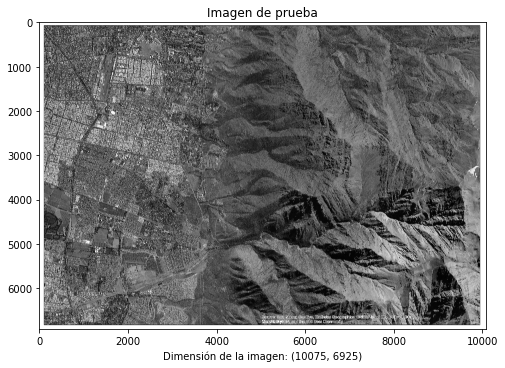

In [7]:
plt.figure(num=1, figsize=(8, 6))
plt.title('Imagen de prueba')
plt.imshow(images[3], cmap='gray')
plt.xlabel(f'Dimensión de la imagen: {images[3].size}')
plt.show() # Para no mostrar etiqueta <matplotlib.image.AxesImage at....>

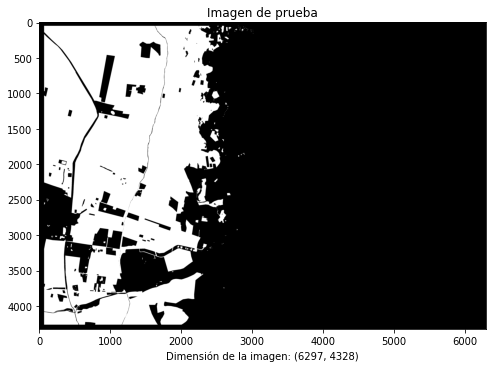

In [8]:
plt.figure(num=1, figsize=(8, 6))
plt.title('Imagen de prueba')
plt.imshow(images[4], cmap='gray')
plt.xlabel(f'Dimensión de la imagen: {images[4].size}')
plt.show() # Para no mostrar etiqueta <matplotlib.image.AxesImage at....>

## Gráficamos múltiples imágenes

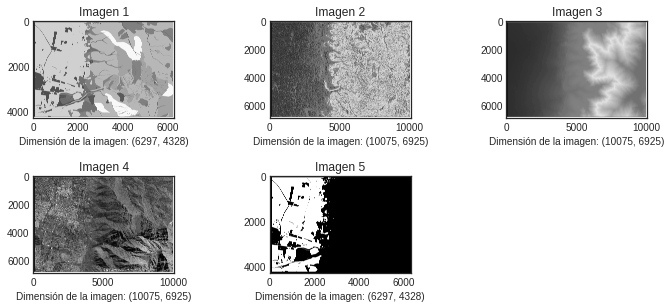

In [9]:
plt.style.use('seaborn-white')
plt.figure(1, figsize=(14,10))

for (idx, img) in enumerate(images[:6]):
    plt.subplot(2, 3, idx+1)
    plt.title(f'Imagen {idx+1}')

    plt.xlabel(f'Dimensión de la imagen: {images[idx].size}')
    plt.imshow(img, cmap='gray')

plt.subplots_adjust(top=0.45, bottom=0.1, left=0.1, right=0.75, wspace=0.3, hspace=0.6) # Importante
plt.show()

## Upscale de la imagen de la mascara
https://www.tutorialkart.com/opencv/python/opencv-python-resize-image/

In [10]:
urban_mask_resize = urban_numpy
print(f'Tamaño de la imagen antes de re-escalar: {urban_mask_resize.shape}')

scale_percent = (origin_numpy.shape[1]/urban_mask_resize.shape[1])
print(f'Escala de conversión: {scale_percent}')

width = int(urban_mask_resize.shape[1] * scale_percent)
height = int(urban_mask_resize.shape[0] * scale_percent)
dim = (width, height+1)

# resize image
resized = cv2.resize(urban_mask_resize, dim, interpolation = cv2.INTER_AREA)

print(f'Tamaño de la imagen despues de re-escalar: {resized.shape}')

Tamaño de la imagen antes de re-escalar: (4328, 6297)
Escala de conversión: 1.5999682388438938
Tamaño de la imagen despues de re-escalar: (6925, 10075)


# Establecemos parámetros para las imágenes del dataset
---

Para generar nuestra base de datos debemos configurar tres (o tal vez más) parámetros, estos son:

- `n_images`: corresponde al número de imágenes que contendra nuestro dataset.
- `crop_width`: corresponde al largo o ancho de una imágen particionada.
- `crop_height`: corresponde al alto de una imágen particionada.

También, debemos recordar que `opencv` y `PIL` trabajan con distintos tipos de datos, en el primer caso se utiliza `numpy` y en segundo se utiliza `PIL`. Al momento de acceder a las dimensiones de una imagen ya sea como arreglo o como imagen, se debe utulizar una de las siguientes funciones:

- En caso de usar `PIL`: `image.size` nos otorgara las dimensiones como una tupla: `(width, height)`.
- En caso de usar `opencv`: `image.size` nos otorgara las dimensiones como un tipo de tupla que tendrá la siguiente forma: `(height, width, channels)`.

In [11]:
height, width = resized.shape # Dimensiones de la imagen original
n_images = 20

In [12]:
print(f'Dimensión de la imagen: (width = {width}, height = {height})')

Dimensión de la imagen: (width = 10075, height = 6925)


In [13]:
crop_width  = int(width - 2*72*scale_percent) // n_images      # División entera, no considera el resto.
crop_height = int(height - 2*55*scale_percent) // n_images    # División entera, no considera el resto.

print(f'Dimensión imagenes pequeñas: {crop_width}, {crop_height}')

Dimensión imagenes pequeñas: 492, 337


In [14]:
init_left = int(72*scale_percent)
left      = width - init_left
init_top  = int(55*scale_percent)
top       = height - init_top

### Creamos una función para hacer los recortes de las distintas imagenes y posteriormente retornamos la lista con las imagenes recortadas

In [15]:
def recorte(imagen_numpy, init_left, left, init_top, top, crop_height, crop_width):
    crop_images = []
    
    for y in range(init_top, top, crop_height):
        for x in range(init_left, left, crop_width):
            
            right  = x + crop_width
            bottom = y + crop_height

            im = Image.fromarray(imagen_numpy[y:bottom, x:right])

           # print('-------------------------------------')      
           # print(f'top:  {y}, bottom: {bottom}')
           # print(f'left: {x}, right:  {right}')
           # print('-------------------------------------\n')

            crop_images.append(im)
    return crop_images

Aqui creamos las dos listas con las imagenes recortadas

In [16]:
print(origin_numpy.shape)
print(resized.shape)
crop_origin = recorte(origin_numpy, init_left, left, init_top, top, crop_height, crop_width)
crop_mask = recorte(resized, init_left, left, init_top, top, crop_height, crop_width)

(6925, 10075)
(6925, 10075)


In [17]:
len(crop_mask) == len(crop_origin)

True

## Visualizamos una imagen particionada

In [35]:
indice = 20

In [36]:
test_img = crop_mask[indice]

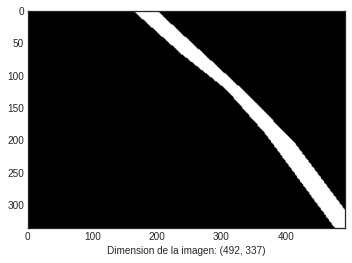

In [37]:
plt.imshow(test_img)
plt.xlabel(f'Dimension de la imagen: {test_img.size}')
plt.show()

In [38]:
test_img = crop_origin[indice]

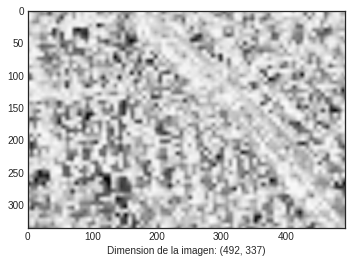

In [39]:
plt.imshow(test_img)
plt.xlabel(f'Dimension de la imagen: {test_img.size}')
plt.show()

In [23]:
#path_origin = "D:\Proyecto deep learning\segmetation-geology\Imagenes recortadas original/"
#path_mask = "D:\Proyecto deep learning\segmetation-geology\Imagenes recortadas mascara/"
path_origin = "./Imagenes_recortadas_original/" #Linux
path_mask = "./Imagenes_recortadas_mascara/"    #Linux

In [24]:
type(crop_mask)

list

## Creamos una función para eliminar las imagenes que contienen dimensiones distintas a la deseada

In [25]:
desired_dim = (crop_width, crop_height)

def removeImages(data, desired_dim):
    for img in data:
        if(img.size != desired_dim):
            data.remove(img)

### Removemos las imagenes

In [26]:
removeImages(crop_origin, desired_dim)
removeImages(crop_mask, desired_dim)

In [27]:
if(not os.path.exists(path_origin)):
    os.mkdir(path_origin)
    
if(not os.path.exists(path_mask)):
    os.mkdir(path_mask)

In [28]:
def guardarImagenes(listado_imagenes,path):
    for x in range(len(listado_imagenes)):
        listado_imagenes[x].save(path+str(x)+".jpg")
    return print("listo")

In [29]:
guardarImagenes(crop_origin,path_origin)
guardarImagenes(crop_mask, path_mask)

listo
listo
